$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\softmax}[1]{\mathrm{softmax}\left({#1}\right)}
$$

# CS236781: Deep Learning
# Tutorial 11: Variational AutoEncoders


## Introduction

In this tutorial, we will cover:

- Discriminative Vs. Generative
- start simple- KDE and GMM

- VAE
    - KL divergence
    - representation trick
    - VAE loss
    - code example


In [1]:
# Setup
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()



# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset 


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
# sklearn imports
from sklearn import mixture
from sklearn.manifold import TSNE

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Discriminative Vs. Generative

recall for our probabalistic notation:

- Domain: $\vec{x}^i \in \set{R}^D$
- Target: $y^i \in \set{Y}$ - typically for classification, a set of classes.

* When did we solve a regresion problem in the course?
* what was the Target space there?

**Discriminative models**, are most of the models we saw in the course so far: we're trying to learn $P(Y|X)$ 
for that type of models, we have to use labels, so we use supervised learning setup.

**Generative models**, are models that learn $P(X)$ rather explicitly (Today), or implicitly (Next week). can also learn $P(X|Y)$ if we know the target space.

and serve two perposes:

1. we can use bayes rule: $(Y|X) = \frac{P(X|Y) P(X)}{P(Y)}$ and since we only like to maximize, we can only look at $P(X|Y) P(X)$, and thus we can classify the example!

2. We can sample the learned distribution $P(X)$ or $P(X|Y)$ and generate new instances !


<center><img src="img/gen_disc.jpg" width=1300 /></center>

## KDE

A bit before we dive into the deep (learning/water), let's see how we might create a generative model for low- dimentional data.

We have N points $X \in \set{R}^2$ where $X_i$ ~ $D$ and we want to learn $D$


In [3]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

simplest way (yet not accurate) to estimate D would be to use a histogram of the samples.

Problem:

* when the values are of a continues grid, each uniqe value would have a column with the hight of one.
    * we can choose in advance the number of bins we want to use
    * each datapoint that will come in a bit will be assined for the bin

1.0

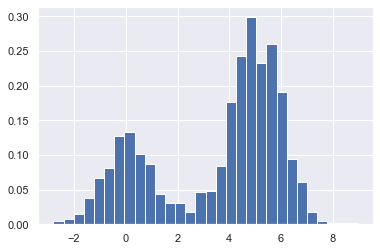

In [4]:
hist = plt.hist(x, bins=30,density=True)
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

* if we don't have high number of datapoints, the setimation could defer.

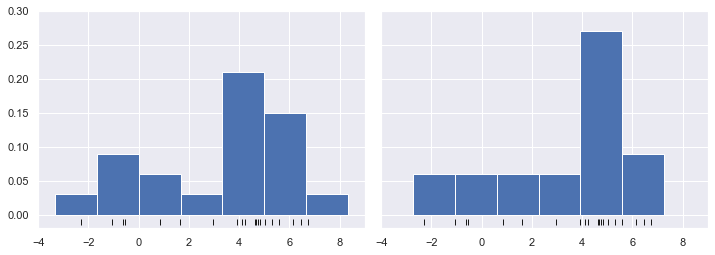

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

to avoid sampling only the mean of each bin, think that instead of stacking blocks we can add a block (with small width) around each point:

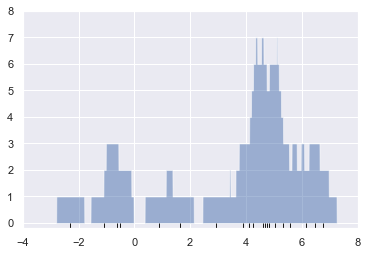

In [6]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

This is starting to look more like a distribution function, yet we need to determine the width of each bin

and more important, it is still discrete.

We can, instead, add a gaussian around each point:

<img src="img/gau.png" width=800 /> 



(-0.02, 0.22)

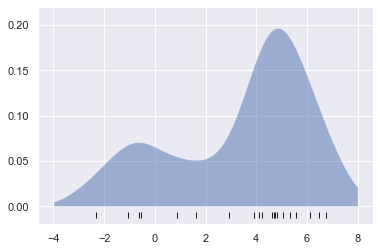

In [7]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

Other way could be to use a Gausian Mixture Model (GMM):

<center><img src="img/gmm.png" width=500 /></center>


And while the original algorithm is unsupervised learning, using labels we can tweek it to learn $P(Y|X)$, where for each new datapoint, we can decide what distribution it is more likely come from.

If you are intrested, you can [watch](https://www.youtube.com/watch?v=XLKoTqGao7U&ab_channel=VictorLavrenko) the EM algorithm

and to experince with code, you may run the code below:

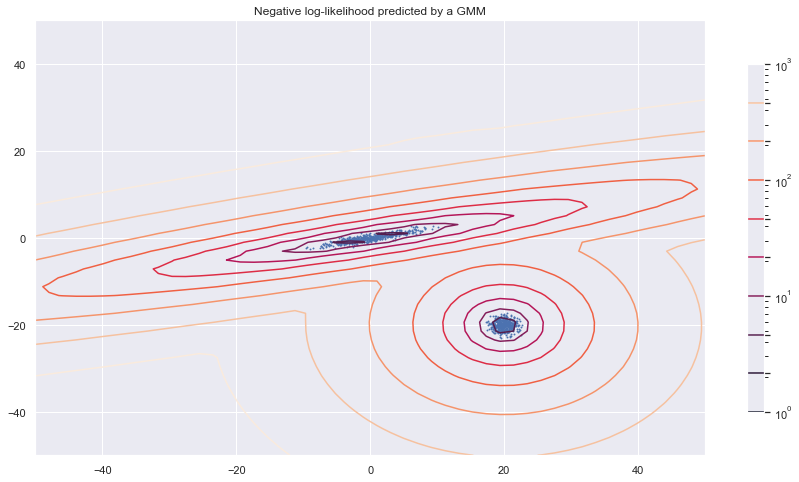

In [8]:
from matplotlib.colors import LogNorm

n_samples = 500

# generate random sample, two components
np.random.seed(0)

# generate spherical data around (20, -20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, -20])

# generate zero centered stretched Gaussian data
C = np.array([[-1.0, -0.7], [3.5, 0.7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(X_train)


# display predicted scores by the model as a contour plot
x = np.linspace(-50.0, 50.0)
y = np.linspace(-50.0, 50.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=(15, 8))
CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)


plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()

And sample points (just $P(X)$) like that:

In [9]:

flat = np.exp(-1*Z.flatten())
flat /= np.sum(flat)
for _ in range(10):
    idx = np.random.choice(a=flat.size, p=flat)
    print(f"samled point:{XX[idx]} with prob:{flat[idx]:.2f}")

samled point:[-3.06122449 -1.02040816] with prob:0.12
samled point:[ 19.3877551 -19.3877551] with prob:0.24
samled point:[ 21.42857143 -21.42857143] with prob:0.04
samled point:[ 19.3877551 -19.3877551] with prob:0.24
samled point:[ 19.3877551 -19.3877551] with prob:0.24
samled point:[-1.02040816 -1.02040816] with prob:0.05
samled point:[1.02040816 1.02040816] with prob:0.05
samled point:[ 19.3877551  -21.42857143] with prob:0.11
samled point:[1.02040816 1.02040816] with prob:0.05
samled point:[ 19.3877551 -19.3877551] with prob:0.24


## Variational-Autoencoder (VAE)

The idea is very similar to AutoEncoder that we've already saw.

Now we can work in an unsupervised fashion. means, we don't need labels.

The idea is to use an Encoder to some latent space that we can enforce with some known distribution, and then project it back to the image space with minimal changes.

<center><img src="img/vae.png" width=1400 /></center>


* In VAE we infer the posterior $P_\theta(z|X)$ using a method calld **Variational Inference (VI)** (hence the name Variational Autoencoder).


* VI: solve an optimization problem in which we model $P_\theta(z|X)$, we will denote by $P$ using a simpler distribution $Q_\psi(z|X)$, denote by $Q$.

* inimize the difference between these distributions using the KL-divergence. (more into details, the loss called **Evidence lower bound** or **ELBO**, you can read about it and how to derive it from [wikipedia](https://en.wikipedia.org/wiki/Evidence_lower_bound))

his makes sense because while we have some knowledge of  X (e.g., we have images of dogs), we have no clue what $z$ looks like!

Had we known what $z$ looks like, we could just formulate this as two mapping problems ($X->z | z->X$) where we have ground-truth for each direction of the mapping.


### Kullback-Leibler divergence

Kullback-Leibler divergence is a metric to measure quasi-distance between 2 distributions:


$$
D_{KL}(P || Q) = \sum_{x \in \mathcal{X}} P(x) log(\frac{P(x)}{Q(x)})
$$

In other words, it is the expectation of the logarithmic difference between the probabilities P and Q.<br>

now you can see why this is a quasi-distance?<br>
$$ D_{KL}(P || Q) \ne D_{KL}(Q || P) $$


So it's a bit confusing, what does it mean for our VAE and what distribusion is the real one?

as we denoted before $p_{\theta}(z|X)$ is the distribution we can learn, and $q_{\phi}(z|X)$ is a simpler distribution we can determine. ($\theta$ is learnable while $\phi$ is deducable)


The first step is to **choose Q**. and a choice that make sence is $\mathcal{N}(0,1)$.
then, we need to understand if we want $ D_{KL}(P || Q) $ or $ D_{KL}(Q || P) $

short ansswer would be $ D_{KL}(P || Q) $.<br>
longer answer you can find [here](https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/)

With some algebra we can proof that there is no need to learn the covariance matix of z, but the varicance is enoght, and log_variance is even easier and serve our perpuse

### The Reparameterization Trick
---
As you recall, in deep neural networks we use **backpropagation** of the gradients to update the weights. In the training process we need to **sample** $z$'s and forward them through the decoder, and they are sampled from $\mathcal{N}(\mu(X), \Sigma(X))$. So normaly, code-wise it would look something like this: `z = torch.normal(mu_x, sigma_x)` or `z = np.normal(mu_x, sigma_x)`.

* What is the problem with that operation?
    * The sampling operation **does not have a gradient!** So we cannot update the encoder with respect to the loss function!
* Solution - **The Reparametrization Trick**:
    * It makes the network differentiable!
    * The trick is as follows:
        * Recall that if you have $x \sim \mathcal{N}(\mu, \Sigma)$ and then you perform standartization, $x_{std}$, so that $\mu=0, \Sigma=1$, then you can revert it back to the original distribution by: $x = \mu +\Sigma^{\frac{1}{2}} x_{std}$.
        * In our case, let $\epsilon \sim \mathcal{N}(0,1)$: $$ z = \mu(X) + \Sigma(X)^{\frac{1}{2}}\epsilon $$
        * No we can take the derivative w.r.t. to $\mu(X), \Sigma(X)$ and backpropagate it through the network!

In [10]:
# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variance of x
    :param device: device to perform calculations on
    :return z: the sampled latent variable
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std

### The VAE loss

all we talked about so far is the KL div of $z$


eventially, we want to reconstract the input image $X$ from this representation.

the VAE Loss would be:

$L(\phi,\theta,x) = R(\hat{X}_{\theta},X) + KL(p_{\theta}(z|X),q_{\phi}(z|X))$

where the first part is the reconstruction loss of the input and the reconstucted image.$\hat{X}_{\theta}$ is infeere from the vector $z$ by the decoder part.

we can simply use pixel-wize BCE (Binary cross enthropy)

In [11]:
def loss_function(recon_x, x, mu, logvar, loss_type='bce'):
    """
    This function calculates the loss of the VAE.
    loss = reconstruction_loss - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param recon_x: the reconstruction from the decoder
    :param x: the original input
    :param mu: the mean given X, from the encoder
    :param logvar: the log-variance given X, from the encoder
    :param loss_type: type of loss function - 'mse', 'l1', 'bce'
    :return: VAE loss
    """
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_error + kl) / x.size(0)  # normalize by batch_size

The Encoder part: we simply use 2 layers MLP

The encoder takes the high-dimensional data, $X \in \mathcal{R}^D$, and encodes in a lower-dimensional latent space vector, $z \in \mathcal{R}^d$, that is, we model $q_{\phi}(z|X)$. 



Since we are in a *variational* environment, and we model a distrubution $q_{\phi}$, the outputs of the encoder are the mean, $\mu(X) \in \mathcal{R}^d$ and the co-variance, $\Sigma(X) \in \mathcal{R}^d$. 
    * Remember that since we assume independce between the latent variables, the co-variance matrix is diagonal and we can represent it as a vector in $\mathcal{R}^d$, where each value represents the variance (the $ii^{th}$ element in the co-variance matrix).

In [12]:
# encoder - q_{\phi}(z|X)
class VaeEncoder(torch.nn.Module):
    """
       This class builds the encoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       :param device: cpu or gpu
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10, device=torch.device("cpu")):
        super(VaeEncoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.device = device
        
        self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                      nn.ReLU())
        
        self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output mu
        self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output logvar


    def bottleneck(self, h):
        """
        This function takes features from the encoder and outputs mu, log-var and a latent space vector z
        :param h: features from the encoder
        :return: z, mu, log-variance
        """
        mu, logvar = self.fc1(h), self.fc2(h)
        # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        z, mu, logvar = VaeEncoder(X)
        """
        h = self.features(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

The decoder takes a lower-dimensional latent space vector, $z \in \mathcal{R}^d$ and decodes it to a high-dimensional *reconstruction* data, $\tilde{X} \in \mathcal{R}^D$ , that is, we model $p_{\theta}(X|z)$. 

In [13]:
# decoder - p_{\theta}(x|z)
class VaeDecoder(torch.nn.Module):
    """
       This class builds the decoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10):
        super(VaeDecoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.x_dim),
                                     nn.Sigmoid())
                                    #Sigmoid normelize in [0,1], like we normelize the input image
                                    #can delete that and norm by a function like tutorial 3.

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        x_reconstruction = VaeDecoder(z)
        """
        x = self.decoder(x)
        return x

In [14]:
class Vae(torch.nn.Module):
    def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu")):
        super(Vae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, num_samples=1):
        """
        This functions generates new data by sampling random variables and decoding them.
        Vae.sample() actually generates new data!
        Sample z ~ N(0,1)
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        return self.decode(z)

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

In [15]:
# define hyper-parameters
BATCH_SIZE = 128  # usually 32/64/128/256
LEARNING_RATE = 1e-3  # for the gradient optimizer
NUM_EPOCHS = 15# 150  # how many epochs to run?
HIDDEN_SIZE = 256  # size of the hidden layers in the networks
X_DIM = 28 * 28  # size of the input dimension
Z_DIM = 10  # size of the latent dimension

Deu to computetional constraints, we're not going to generate big images, but going to go back to mnist

In [17]:
transform = torchvision.transforms.ToTensor()

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


0it [00:00, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


0it [00:00, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


0it [00:00, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


0it [00:00, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...


C:\Users\moshe\anaconda3\envs\cs3600-tut\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


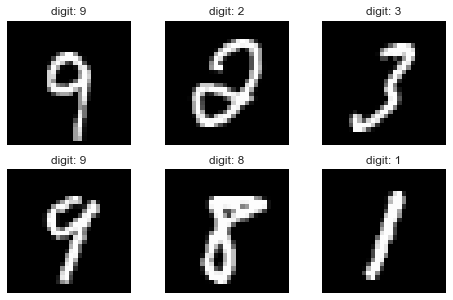

In [18]:
fig = plt.figure(figsize=(8 ,5))
samples, labels = next(iter(train_loader))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i][0, :, :].data.cpu().numpy(), cmap='gray')
    title = "digit: " + str(labels[i].data.cpu().item())
    ax.set_title(title)
    ax.set_axis_off()

In [19]:
# create our model
vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)

# optimizer 
vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)

# save the losses from each epoch, we might want to plot it later
train_losses = []

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    batch_losses = []
    for batch_i, batch in enumerate(train_loader):
        # forward pass
        x = batch[0].to(device).view(-1, X_DIM)  # just the images
        x_recon, mu, logvar, z = vae(x)
        # calculate the loss
        loss = loss_function(x_recon, x, mu, logvar, loss_type='bce')
        # optimization (same 3 steps everytime)
        vae_optim.zero_grad()
        loss.backward()
        vae_optim.step()
        # save loss
        batch_losses.append(loss.data.cpu().item())
    train_losses.append(np.mean(batch_losses))
    print("epoch: {} training loss: {:.5f} epoch time: {:.3f} sec".format(epoch, train_losses[-1],
                                                                          time.time() - epoch_start_time))
    
    
"""
# save
fname = "./vae_mnist_" + str(NUM_EPOCHS) + "_epochs.pth"
torch.save(vae.state_dict(), fname)
print("saved checkpoint @", fname)

# load
vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
vae.load_state_dict(torch.load(fname))
print("loaded checkpoint from", fname)
"""

epoch: 0 training loss: 171.57769 epoch time: 10.520 sec
epoch: 1 training loss: 128.90011 epoch time: 11.004 sec
epoch: 2 training loss: 122.67897 epoch time: 11.892 sec
epoch: 3 training loss: 119.56529 epoch time: 13.966 sec
epoch: 4 training loss: 117.53008 epoch time: 13.197 sec
epoch: 5 training loss: 116.11026 epoch time: 13.531 sec
epoch: 6 training loss: 114.98391 epoch time: 13.474 sec
epoch: 7 training loss: 114.12774 epoch time: 14.079 sec
epoch: 8 training loss: 113.46270 epoch time: 12.615 sec
epoch: 9 training loss: 112.87070 epoch time: 12.998 sec
epoch: 10 training loss: 112.36000 epoch time: 12.948 sec
epoch: 11 training loss: 111.94424 epoch time: 12.560 sec
epoch: 12 training loss: 111.51269 epoch time: 12.668 sec
epoch: 13 training loss: 111.15255 epoch time: 12.881 sec
epoch: 14 training loss: 110.82297 epoch time: 13.313 sec


'\n# save\nfname = "./vae_mnist_" + str(NUM_EPOCHS) + "_epochs.pth"\ntorch.save(vae.state_dict(), fname)\nprint("saved checkpoint @", fname)\n\n# load\nvae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)\nvae.load_state_dict(torch.load(fname))\nprint("loaded checkpoint from", fname)\n'

Now we can sample the model

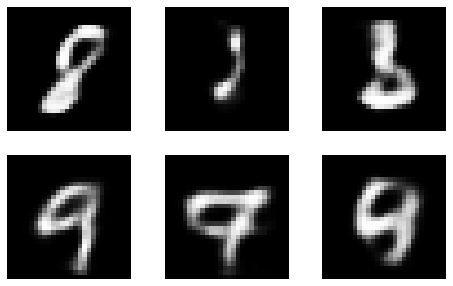

In [20]:
# now let's sample from the vae
n_samples = 6
vae_samples = vae.sample(num_samples=n_samples).view(n_samples, 28, 28).data.cpu().numpy()
fig = plt.figure(figsize=(8 ,5))
for i in range(vae_samples.shape[0]):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(vae_samples[i], cmap='gray')
    ax.set_axis_off()

#### Investigate $z$ with interpulation

we can create:
$$ z_{new} = \alpha z_1 + (1-\alpha) z_2, \alpha \in [0,1] $$ 

and see the transition between the 2 images.

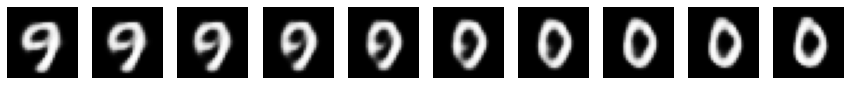

In [21]:
alphas = np.linspace(0.1, 1, 10)
# take 2 samples
sample_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, drop_last=True)
it = iter(sample_dataloader)
samples, labels = next(it)
while labels[0] == labels[1]:
    # make sure they are different digits
    samples, labels = next(it)
x_1, x_2 = samples

# get their latent representation
_,_, _, z_1 = vae(x_1.view(-1, X_DIM).to(device))
_,_, _, z_2 = vae(x_2.view(-1, X_DIM).to(device))

# let's see the result
fig = plt.figure(figsize=(15 ,8))
for i, alpha in enumerate(alphas):
    z_new = alpha * z_1 + (1 - alpha) * z_2
    x_new = vae.decode(z_new)
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(x_new.view(28, 28).cpu().data.numpy(), cmap='gray')
    ax.set_axis_off()

Let's see what we've learned with T-SNE, to reduce dimention and cluster the outputs :)

Text(0.5, 1.0, 't-SNE of VAE Latent Space on MNIST')

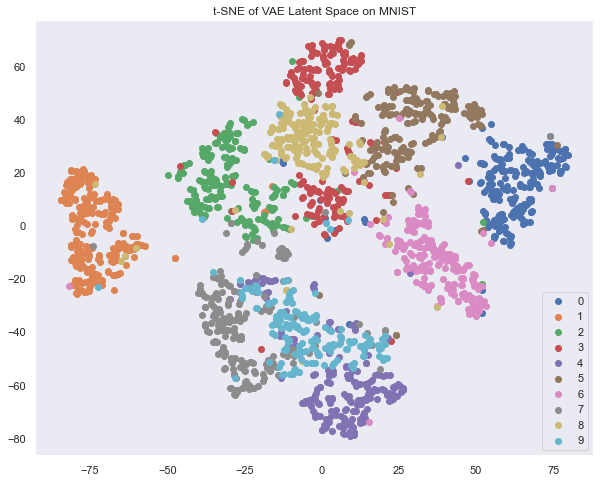

In [22]:
# take 2000 samples
num_samples = 2000
sample_dataloader = DataLoader(train_dataset, batch_size=num_samples, shuffle=True, drop_last=True)
samples, labels = next(iter(sample_dataloader))

labels = labels.data.cpu().numpy()
# decode the samples
_,_, _, z = vae(samples.view(num_samples, X_DIM).to(device))

# t-SNE
perplexity = 15.0
t_sne = TSNE(n_components=2, perplexity=perplexity)
z_embedded = t_sne.fit_transform(z.data.cpu().numpy())

# plot
fig = plt.figure(figsize=(10 ,8))
ax = fig.add_subplot(1, 1, 1)
for i in np.unique(labels):
    ax.scatter(z_embedded[labels==i,0], z_embedded[labels==i, 1], label=str(i))
ax.legend()
ax.grid()
ax.set_title("t-SNE of VAE Latent Space on MNIST")

#### Thanks

**Credits**

This tutorial was written by [Moshe Kimhi](https://www.linkedin.com/in/moshekimhi/)<br>
To re-use, please provide attribution and link to the original.


some code snips from:<br>
[kernel-density-estimation](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

images sources:
https://developers.google.com/machine-learning/gan/generator<br>
https://towardsdatascience.com/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775